In [1]:
pip install transformers tensorflow scikit-learn matplotlib datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from transformers import TFBertModel, BertTokenizer
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Lambda

In [3]:
# Load GoEmotions dataset
from datasets import load_dataset
dataset = load_dataset("go_emotions")
data = dataset["train"].to_pandas()

# Preprocessing
texts = data['text'].values
labels = data['labels'].apply(lambda x: x[0] if len(x) > 0 else -1)
data = data[labels != -1]  # Remove entries without labels
texts = data['text'].values
labels = data['labels'].apply(lambda x: x[0]).values
num_classes = len(np.unique(labels))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


README.md:   0%|          | 0.00/9.40k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/350k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [4]:
# Load BERT model and tokenizer
bert_model = TFBertModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
max_len = 100

# Tokenize texts with BERT tokenizer
tokenized_data = tokenizer(
    list(texts),
    max_length=max_len,
    padding="max_length",
    truncation=True,
    return_tensors="tf"
)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [5]:
# Train-test split
X_train_input_ids, X_test_input_ids, y_train, y_test = train_test_split(
    tokenized_data["input_ids"].numpy(),
    labels,
    test_size=0.2,
    random_state=42
)

X_train_attention_mask, X_test_attention_mask = train_test_split(
    tokenized_data["attention_mask"].numpy(),
    test_size=0.2,
    random_state=42
)


In [6]:
# Encode labels for multi-class classification
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))

# Define model input layers
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

In [7]:
# Make BERT trainable for fine-tuning
bert_model.trainable = True

# Wrap the BERT model in a Lambda layer with explicit output_shape
bert_output = Lambda(
    lambda x: bert_model(input_ids=x[0], attention_mask=x[1])[0],
    output_shape=(max_len, bert_model.config.hidden_size),
    name="BERT_Embedding"
)([input_ids, attention_mask])

# Add LSTM and Dense layers
x = Bidirectional(LSTM(128, return_sequences=False))(bert_output)
x = Dropout(0.5)(x)  # Regularization
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Regularization
output = Dense(num_classes, activation='softmax')(x)

# Define the complete model
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile the model with a learning rate scheduler
initial_learning_rate = 1e-5
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

model.compile(optimizer=Adam(learning_rate=initial_learning_rate),
              loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ BERT_Embedding (Lambda)   │ (None, 100, 768)       │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 256)            │        918,528 │ BERT_Embedding[0][0]   │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         32,896 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 28)             │          3,612 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 955,036 (3.64 MB)

 Trainable params: 955,036 (3.64 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the model
batch_size = 16
epochs = 10

history = model.fit(
    [X_train_input_ids, X_train_attention_mask],
    y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    class_weight=class_weights,  # Add class weights
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)


Epoch 1/10
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 84s 40ms/step - accuracy: 0.0324 - loss: 3.4690 - val_accuracy: 0.0567 - val_loss: 3.2938 - learning_rate: 1.0000e-05
Epoch 2/10
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 66s 38ms/step - accuracy: 0.0435 - loss: 3.4221 - val_accuracy: 0.0875 - val_loss: 3.2753 - learning_rate: 1.0000e-05
Epoch 3/10
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 67s 38ms/step - accuracy: 0.0460 - loss: 3.3349 - val_accuracy: 0.1038 - val_loss: 3.2637 - learning_rate: 1.0000e-05
Epoch 4/10
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 67s 38ms/step - accuracy: 0.0546 - loss: 3.3805 - val_accuracy: 0.1237 - val_loss: 3.2436 - learning_rate: 1.0000e-05
Epoch 5/10
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 67s 39ms/step - accuracy: 0.0621 - loss: 3.2334 - val_accuracy: 0.1352 - val_loss: 3.2198 - learning_rate: 1.0000e-05
Epoch 6/10
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 67s 38ms/step - accuracy: 0.0677 - loss: 3.2571 - val_accuracy: 0.1441 - val_loss: 3.1855 - learning_rate: 1.0000e-05
Epoch 7/10
1737/1737 ━━━━━━━━━━━━━━━━━━━

In [9]:
# Evaluate the model
y_pred_probs = model.predict([X_test_input_ids, X_test_attention_mask])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Metrics
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred))

272/272 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step
F1 Score: 0.1671
Precision: 0.3271
Recall: 0.1808

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.07      0.12       863
           1       0.23      0.33      0.27       427
           2       0.39      0.25      0.30       321
           3       0.21      0.03      0.05       411
           4       0.19      0.04      0.06       523
           5       0.18      0.21      0.19       191
           6       0.10      0.25      0.14       237
           7       0.21      0.65      0.32       368
           8       0.12      0.14      0.13       109
           9       0.08      0.03      0.04       191
          10       0.11      0.20      0.14       311
          11       0.09      0.20      0.12       117
          12       0.03      0.41      0.06        49
          13       0.07      0.40      0.12       149
          14       0.05      0.14      0.07       101
          15     

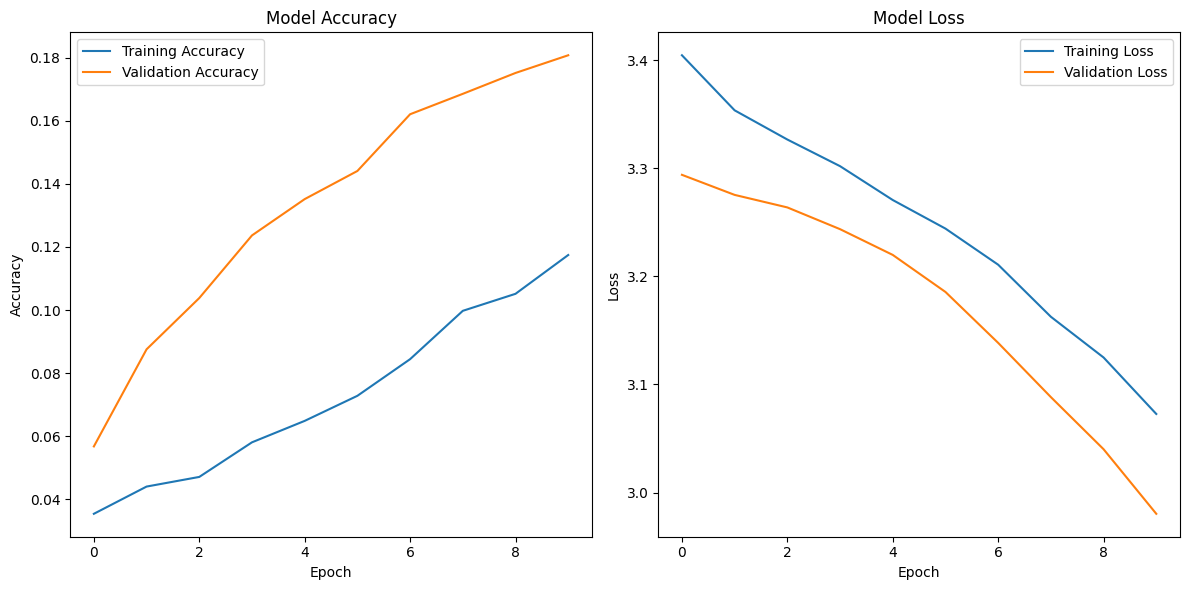

In [10]:
# Plot training history
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

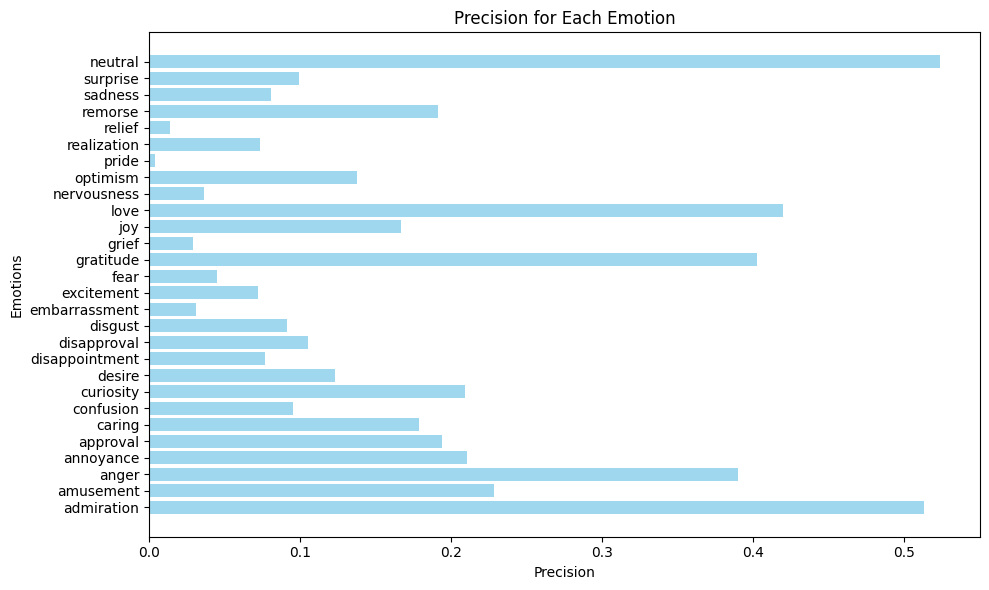

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

# Example: Replace with your emotion class names
emotion_labels = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring",
    "confusion", "curiosity", "desire", "disappointment", "disapproval",
    "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief",
    "joy", "love", "nervousness", "optimism", "pride", "realization",
    "relief", "remorse", "sadness", "surprise", "neutral"
]

# Calculate precision, recall, and F1-score for each emotion
precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
    y_true, y_pred, labels=range(len(emotion_labels))
)

# Calculate Accuracy
accuracies = []
for i in range(len(emotion_labels)):
    correct_predictions = ((y_true == i) & (y_pred == i)).sum()
    total_samples = (y_true == i).sum()
    accuracies.append(correct_predictions / total_samples if total_samples > 0 else 0)

# Create a DataFrame for easier visualization
metrics_df = pd.DataFrame({
    'Emotion': emotion_labels,
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class,
    'Accuracy': accuracies
})

# Plot Precision
plt.figure(figsize=(10, 6))
plt.barh(metrics_df['Emotion'], metrics_df['Precision'], color='skyblue', alpha=0.8)
plt.title('Precision for Each Emotion')
plt.xlabel('Precision')
plt.ylabel('Emotions')
plt.tight_layout()
plt.show()


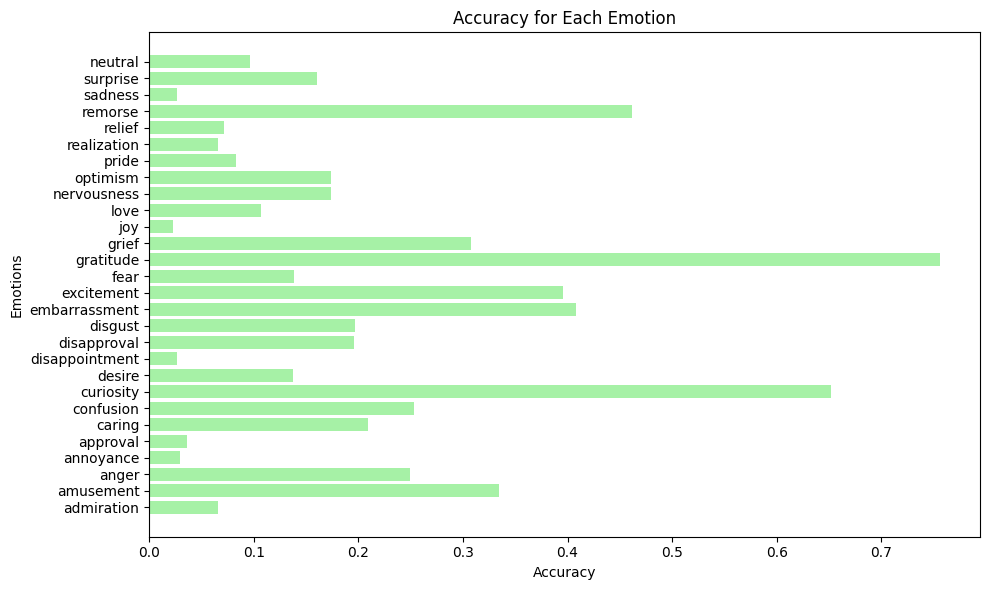

In [12]:

# Plot Accuracy
plt.figure(figsize=(10, 6))
plt.barh(metrics_df['Emotion'], metrics_df['Accuracy'], color='lightgreen', alpha=0.8)
plt.title('Accuracy for Each Emotion')
plt.xlabel('Accuracy')
plt.ylabel('Emotions')
plt.tight_layout()
plt.show()


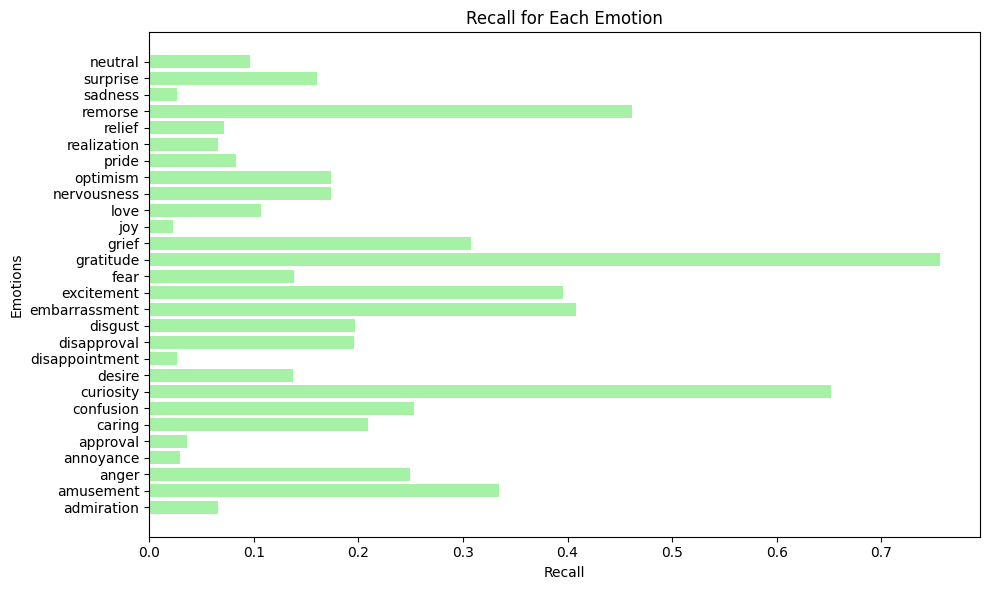

In [13]:
# Plot Recall
plt.figure(figsize=(10, 6))
plt.barh(metrics_df['Emotion'], metrics_df['Recall'], color='lightgreen', alpha=0.8)
plt.title('Recall for Each Emotion')
plt.xlabel('Recall')
plt.ylabel('Emotions')
plt.tight_layout()
plt.show()

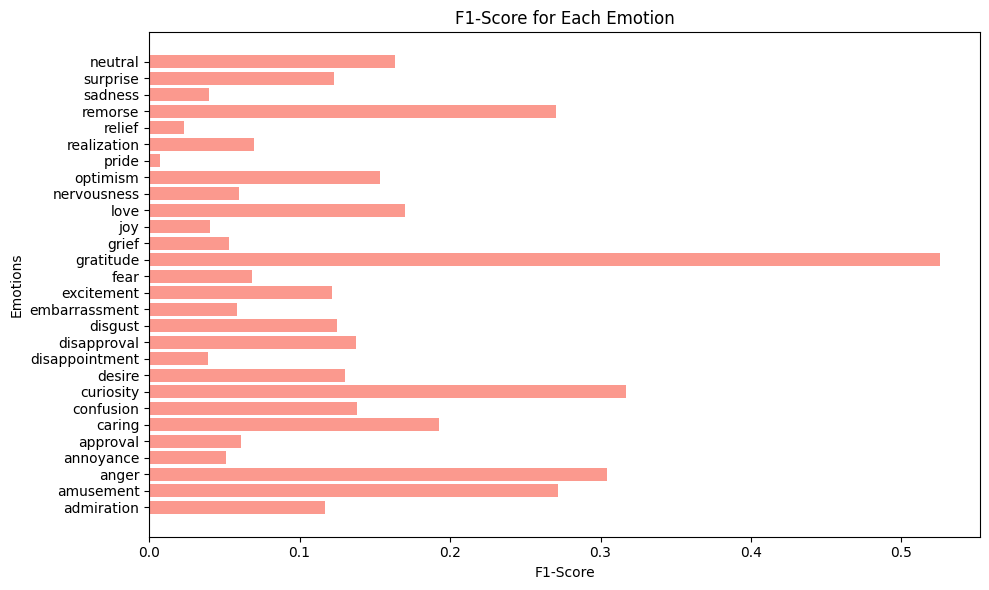

In [14]:
# Plot F1-Score
plt.figure(figsize=(10, 6))
plt.barh(metrics_df['Emotion'], metrics_df['F1-Score'], color='salmon', alpha=0.8)
plt.title('F1-Score for Each Emotion')
plt.xlabel('F1-Score')
plt.ylabel('Emotions')
plt.tight_layout()
plt.show()